In [12]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import requests as reqs
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint  # For gradient checkpointing
from torch.cuda.amp import autocast, GradScaler  # For mixed-precision training
import matplotlib.pyplot as plt
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import zipfile
import urllib.request
import shutil
import random
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


# Setting the device for PyTorch; use CUDA if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

# Defining a custom label encoder for the classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}
    def get_label(self, idx):
        return list(self.labels.keys())[idx]
    def get_idx(self, label):
        return self.labels.get(label)

# Initializing label encoder with 21 classes and testing its functionality
encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

# Printing each class with its corresponding index
for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

# Defining a custom dataset class for handling image data
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)  # Convert to NumPy array for Albumentations

        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        # Apply Albumentations transforms if available
        if self.transform:
            augmented = self.transform(image=image)  # Pass image as named argument
            image = augmented["image"]

        return image, label

def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()
    # Getting the full path for the images
    img_path = "/kaggle/input/food-101/food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]
    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')
        imgs.append(img)
    imgs = np.array(imgs)
    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"      
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])      
    # Adding the full path to the data frame
    imgs['path'] = full_path
    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)
    return imgs

# Preparing training and testing dataframes
train_df = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_df = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')
# Printing the count of images per label in the training set
print(train_imgs.groupby(["label"]).count())

cuda
apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
other 20
                     path
label                    
apple_pie             750
baby_back_ribs        750
baklava               750
beef_carpaccio        750
beef_tartare          750
beet_salad            750
beignets              750
bibimbap              750
bread_pudding         750
breakfast_burrito     750
bruschetta            750
caesar_salad          750
cannoli               750
caprese_salad         750
carrot_cake           750
ceviche               750
cheese_plate          750
cheesecake            750
chicken_curry         750
chicken_quesadilla    750
other               60750


In [4]:
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

train_imgs.head(3)


,label,path
2487039,other,/kaggle/input/food-101/food-101/food-101/image...
2756777,caprese_salad,/kaggle/input/food-101/food-101/food-101/image...
3182251,cheese_plate,/kaggle/input/food-101/food-101/food-101/image...


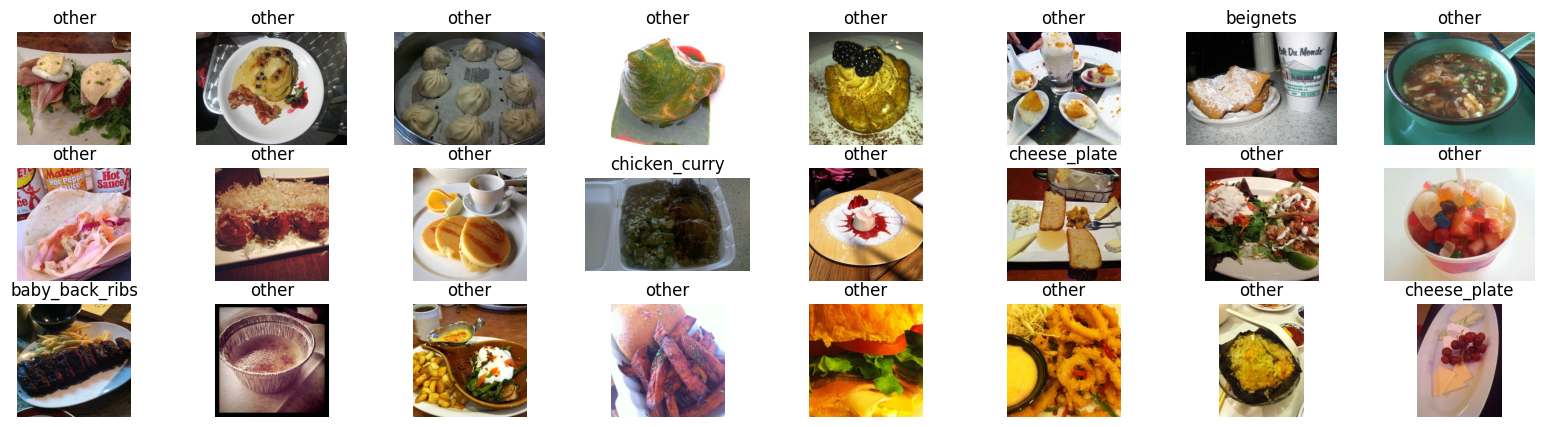

In [5]:
plt.figure(figsize=(20, 5))
num_rows = 3
num_cols = 8
for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])
    label = train_imgs.label.iloc[random_idx]
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 2. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. Classes (top-20 + 'other')
classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

class LabelEncoder21:
    def __init__(self, labels):
        self.label2idx = {lab:i for i,lab in enumerate(labels)}
    def encode(self, label):
        return self.label2idx.get(label, self.label2idx['other'])
    def decode(self, idx):
        return list(self.label2idx.keys())[idx]

encoder = LabelEncoder21(classes_21)
num_classes = len(classes_21)

# 4. Prepare DataFrames

def prep_df(meta_path):
    lines = open(meta_path).read().splitlines()
    base_path = "/kaggle/input/food-101/food-101/food-101/images/"
    rows = []
    for ln in lines:
        cls, img = ln.split('/')
        lbl = cls if cls in encoder.label2idx else 'other'
        path = os.path.join(base_path, f"{cls}/{img}.jpg")
        rows.append((path, encoder.encode(lbl)))
    df = pd.DataFrame(rows, columns=['path','label'])
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df


train_df = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_df = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

# 5. Dataset
class Food21Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        path, label = self.df.iloc[idx]
        img = Image.open(path)
        if img.mode != 'RGB': img = img.convert('RGB')
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label, idx

# 6. Transforms
tf_train = A.Compose([
    A.Resize(224,224), A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])
tf_test = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

train_ds = Food21Dataset(train_df, transform=tf_train)
test_ds  = Food21Dataset(test_df,  transform=tf_test)

# Indexed loaders for label correction
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
indexed_loader = train_loader  # same loader yields idx

# 7. Model
class ResNetSMP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.fc = nn.Linear(base.fc.in_features, num_classes)
    def forward(self,x):
        f = self.backbone(x).view(x.size(0),-1)
        return self.fc(f)
    def extract(self,x):
        with torch.no_grad():
            return self.backbone(x).view(x.size(0),-1)

model = ResNetSMP(num_classes).to(device)

# 8. SMP functions
def extract_features(model, loader):
    model.eval()
    feats, labels, idxs = [], [], []
    with torch.no_grad():
        for imgs, labs, ids in tqdm(loader, desc="Extracting"):
            imgs=imgs.to(device)
            f = model.extract(imgs).cpu()
            feats.append(f)
            labels.append(labs)
            idxs.append(ids)
    return torch.cat(feats), torch.cat(labels), torch.cat(idxs)

def select_prototypes(feats, labels, samples=500, protos=5):
    selected = {}
    for c in range(num_classes):
        idx = (labels==c).nonzero(as_tuple=True)[0]
        if len(idx)==0: continue
        sel = idx[torch.randperm(len(idx))[:samples]]
        fsub=feats[sel]
        sim = cosine_similarity(fsub.numpy())
        th = np.percentile(sim,60)
        dens = (sim>th).sum(1)
        top = dens.argsort()[-protos:]
        selected[c]=fsub[top]
    return selected

def correct_labels(model, loader):
    feats, labs, ids = extract_features(model, loader)
    protos = select_prototypes(feats, labs)
    new = torch.zeros_like(labs)
    for i in range(len(feats)):
        f=feats[i].unsqueeze(0)
        sims=[F.cosine_similarity(f,protos[c]).mean().item() if c in protos else -1e6 for c in range(num_classes)]
        new[i]=torch.tensor(np.argmax(sims))
    return new

# 9. Training setup
opt = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
crit = nn.CrossEntropyLoss()
history=[]

# 10. Iterative SMP training
for epoch in range(15):
    print(f"Epoch {epoch+1}/15")
    # Phase 1: warmup
    if epoch<5:
        pseudo=None; alpha=0.0
    else:
        pseudo=correct_labels(model, indexed_loader); alpha=0.5
    # Train
    model.train()
    for imgs, labs, ids in tqdm(train_loader,desc="Train"):
        imgs, labs = imgs.to(device), labs.to(device)
        out = model(imgs)
        loss = crit(out,labs) if pseudo is None else (1-alpha)*crit(out,labs)+alpha*crit(out,pseudo[ids].to(device))
        opt.zero_grad(); loss.backward(); opt.step()
    sched.step()
    # Eval
    model.eval()
    preds, trues = [],[]
    with torch.no_grad():
        for imgs,lbs,_ in test_loader:
            out=model(imgs.to(device)).argmax(1).cpu(); preds+=out.tolist(); trues+=lbs.tolist()
    acc=accuracy_score(trues,preds); print(f"Acc: {acc*100:.2f}%")
    history.append(acc)

# Plot
plt.plot(range(1,16), [h*100 for h in history], marker='o'); plt.xlabel('Epoch'); plt.ylabel('Acc (%)'); plt.grid(True); plt.show()


Using device: cuda
Epoch 1/15


Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 86.30%
Epoch 2/15


Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 89.97%
Epoch 3/15


Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 91.39%
Epoch 4/15


Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 91.47%
Epoch 5/15


Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 91.87%
Epoch 6/15


Extracting:   0%|          | 0/1184 [00:00<?, ?it/s]

Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 88.67%
Epoch 7/15


Extracting:   0%|          | 0/1184 [00:00<?, ?it/s]

Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 89.42%
Epoch 8/15


Extracting:   0%|          | 0/1184 [00:00<?, ?it/s]

Train:   0%|          | 0/1184 [00:00<?, ?it/s]

Acc: 89.33%
Epoch 9/15


Extracting:   0%|          | 0/1184 [00:00<?, ?it/s]